In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
import time

def read_geocsv(*args, **kwargs):
    df = pd.read_csv(*args, **kwargs)    
    df["geometry"] = [wkt.loads(s) for s in df["geometry"]] 
    gdf = gpd.GeoDataFrame(df)
    gdf.crs = {'init': 'epsg:4326'}
    return gdf
gpd.read_geocsv = read_geocsv

### redo the intersection to only keep maz_id from the right hand dataframe
This saves parcels which intersect with more than one maz to a csv called joined.csv.  We can then read joined.csv in the next cell and not have to run this cell (which takes a while) again.

In [4]:
def intersect(lower_gdf, upper_gdf):
    return gpd.sjoin(lower_gdf, upper_gdf, how="inner", op='intersects')
 
parcels = gpd.read_geocsv("parcels.csv")
mazs = gpd.read_geocsv("mazs.csv")
mazs = gpd.GeoDataFrame(mazs[["maz_id", "geometry"]])
joined = intersect(parcels, mazs)
overlaps = joined.apn.value_counts().loc[lambda x: x > 1]
joined.drop("index_right", axis=1)[joined.apn.isin(overlaps.index)].to_csv("joined.csv", index=False)

### read data to do parcel splits

In [57]:
mazs = gpd.read_geocsv("mazs.csv").set_index("maz_id").drop(["Shape_Area", "Shape_Leng"], axis=1)
joined = gpd.read_geocsv("joined.csv").set_index("apn")

### functions for parcel splits

In [2]:
def compute_area(gdf):
    gdf.crs = {'init': 'epsg:4326'}
    return gdf.to_crs(epsg=3395).area

def merge_slivers_back_to_shapes(shapes, slivers):
    for label, row in slivers.iterrows():
        distances = [
            row.geometry.distance(row2.geometry)
            for _, row2 in shapes.iterrows()
        ]
        min_ind = np.argmin(distances)
        closest_shape = shapes.iloc[min_ind]
        closest_index = shapes.index[min_ind]

        union = closest_shape.geometry.union(row.geometry)
        shapes = shapes.set_value(closest_index, "geometry", union)

    return shapes

def compute_pct_area(df, total_area):
    df["calc_area"] = compute_area(df).values
    df["pct_area"] = df["calc_area"] / total_area 
    return df
    
def split_parcel(parcel, split_shapes, dont_split_pct_cutoff=.01, proportional_fields=[], drop_not_in_maz=False):
    try:
        overlay = gpd.overlay(parcel, split_shapes.reset_index(), how='identity')
    except:
        print "Parcel failed"
        return

    overlay = compute_pct_area(overlay, compute_area(parcel).sum())

    # now we need to make sure we don't split off very small portions of the parcel
    split = overlay[overlay.pct_area >= dont_split_pct_cutoff].copy()
    dont_split = overlay[overlay.pct_area < dont_split_pct_cutoff]
    
    split = merge_slivers_back_to_shapes(split, dont_split)
    
    if drop_not_in_maz:
        split = split[~split.maz_id.isnull()]
    
    # have to recompute merge of slivers
    split = compute_pct_area(split, compute_area(split).sum())
    
    # divvy these fields up by the percent area
    for fld in proportional_fields:
        split[fld] *= split.pct_area
    
    return split

### do parcel splits
This creates a file called split.csv which contains all the split geometries.  This file is read in the next cell and so cells before this point don't have to be run again.

In [60]:
apn_counts = joined.index.value_counts()
bad_apns = ["999 999999999"]
proportional_fields = ["bldg_sqft", "impr_val", "land_val", "nres_sqft", "res_units"]

print time.ctime()

cnt = 0
new_parcels = []
for apn, _ in apn_counts.iteritems():
    if apn in bad_apns: continue
    subset = joined.loc[apn]
    ret = split_parcel(subset.head(1).drop("maz_id", axis=1), mazs[mazs.index.isin(subset.maz_id)],
                       proportional_fields=[], drop_not_in_maz=True, dont_split_pct_cutoff=.03)
    if ret is None: continue
    ret["orig_apn"] = apn
    # make a new unique apn when we split a parcel
    ret["apn"] = [apn + "-" + str(i+1) for i in range(len(ret))]
    new_parcels.append(ret)
    cnt += 1
    if cnt % 100 == 0: print "Done %d of %d" % (cnt, len(apn_counts))

new_parcels = pd.concat(new_parcels)
new_parcels.to_csv("split.csv", index=False)
print time.ctime()

Tue Sep 26 17:55:43 2017
Done 100 of 12940
Done 200 of 12940
Done 300 of 12940
Done 400 of 12940
Done 500 of 12940
Done 600 of 12940
Done 700 of 12940
Done 800 of 12940
Done 900 of 12940
Done 1000 of 12940
Done 1100 of 12940
Done 1200 of 12940
Done 1300 of 12940
Done 1400 of 12940
Parcel failed
Done 1500 of 12940
Done 1600 of 12940
Done 1700 of 12940
Done 1800 of 12940
Done 1900 of 12940
Done 2000 of 12940
Done 2100 of 12940
Done 2200 of 12940
Done 2300 of 12940
Done 2400 of 12940
Done 2500 of 12940
Done 2600 of 12940
Done 2700 of 12940
Done 2800 of 12940
Done 2900 of 12940
Done 3000 of 12940
Done 3100 of 12940
Done 3200 of 12940
Done 3300 of 12940
Done 3400 of 12940
Done 3500 of 12940
Done 3600 of 12940
Done 3700 of 12940
Done 3800 of 12940
Done 3900 of 12940
Done 4000 of 12940
Done 4100 of 12940
Done 4200 of 12940
Done 4300 of 12940
Done 4400 of 12940
Done 4500 of 12940
Done 4600 of 12940
Done 4700 of 12940
Done 4800 of 12940
Done 4900 of 12940
Done 5000 of 12940
Done 5100 of 12940
D

### Read split parcels and merge with parcels which don't have intersections
(drop parcels which have been split)

In [3]:
split_parcels = gpd.read_geocsv("split.csv", index_col="apn")
parcels = gpd.read_geocsv("parcels.csv", index_col="apn")
parcels["orig_apn"] = parcels.index
split_parcels = gpd.GeoDataFrame(
    pd.concat([parcels[~parcels.index.isin(split_parcels.orig_apn)], split_parcels]))
buildings = gpd.read_geocsv("buildings.csv", low_memory=False)
buildings["building_id_tmp"] = buildings.index

### now we join buildings to split parcels

In [4]:
joined_buildings = gpd.sjoin(buildings, split_parcels)

### identify overlaps of buildings and split parcels

In [5]:
cnts = joined_buildings.index.value_counts().loc[lambda x: x > 1]
overlaps = joined_buildings.loc[cnts.index].copy()
print len(cnts)
len(overlaps)

114159


254256

In [7]:
def compute_overlap_areas(overlaps, overlapees):
    '''
    After a spatial join is done, this computes the actual area of the overlap.
    overlaps is the result of the spatial join (which contains geometry for the overlaper)
    overlapees is the geometry of the right side of the join
    the "index_right" column of overlaps should be the index of overlapees
    '''
    total_overlaps = len(overlaps)
    cnt = 0
    overlap_area = []
    for index, overlap in overlaps.iterrows():
        overlapee = overlapees.loc[overlap.index_right]
        #ax = overlaper.head(1).plot(alpha=.5)
        #overlapee.loc[overlaper.index_right].tail(1).plot(ax=ax, color="red")
        try:
            overlap_poly = gpd.overlay(gpd.GeoDataFrame([overlap]), gpd.GeoDataFrame([overlapee]), how="intersection")
        except:
            overlap_area.append(np.nan)
            print "Failed:", index
            continue
        cnt += 1
        if cnt % 25 == 0:
            print "Finished %d of %d" % (cnt, total_overlaps)
        if len(overlap_poly) == 0:
            overlap_area.append(0)
            continue
        overlap_area.append(compute_area(overlap_poly).values[0])

    return pd.Series(overlap_area, index=overlaps.index)

print time.ctime()
overlapping_areas = compute_overlap_areas(overlaps, split_parcels)
print time.ctime()

# write it out
pd.DataFrame({"overlapping_areas": overlapping_areas}).to_csv("overlapping_areas.csv")

overlapping_areas

Mon Oct  2 10:15:50 2017
Finished 25 of 254256
Finished 50 of 254256
Finished 75 of 254256
Finished 100 of 254256
Finished 125 of 254256
Finished 150 of 254256
Finished 175 of 254256
Finished 200 of 254256
Finished 225 of 254256
Finished 250 of 254256
Finished 275 of 254256
Finished 300 of 254256
Finished 325 of 254256
Finished 350 of 254256
Finished 375 of 254256
Finished 400 of 254256
Finished 425 of 254256
Finished 450 of 254256
Failed: 4364
Finished 475 of 254256
Finished 500 of 254256
Finished 525 of 254256
Finished 550 of 254256
Finished 575 of 254256
Finished 600 of 254256
Finished 625 of 254256
Finished 650 of 254256
Finished 675 of 254256
Finished 700 of 254256
Finished 725 of 254256
Finished 750 of 254256
Finished 775 of 254256
Finished 800 of 254256
Finished 825 of 254256
Finished 850 of 254256
Finished 875 of 254256
Finished 900 of 254256
Finished 925 of 254256
Finished 950 of 254256
Finished 975 of 254256
Finished 1000 of 254256
Finished 1025 of 254256
Finished 1050 of 254

KeyboardInterrupt: 

Failed: 1761
Failed: 132514
Finished 7375 of 254256


Exception AttributeError: AttributeError("'IndexStreamHandle' object has no attribute '_ptr'",) in <bound method IndexStreamHandle.__del__ of <rtree.index.IndexStreamHandle object at 0x125f269d0>> ignored


KeyboardInterrupt: 

#### Compute the max overlapping percent area for each building footprint - I mean, the percentage overlap for the parcel with which a building overlaps the most

In [6]:
overlapping_area = pd.read_csv("overlapping_areas.csv", index_col="index").overlapping_areas
overlaps["overlapping_area"] = overlapping_area
large_overlaps = overlaps[overlaps.overlapping_area.fillna(0) > .03].copy()
overlapping_area = large_overlaps.overlapping_area
overlapping_pct_area = overlapping_area / overlapping_area.groupby(overlapping_area.index).transform('sum')
large_overlaps["overlapping_pct_area"] = overlapping_pct_area
max_overlapping_pct_area = overlapping_pct_area.groupby(overlapping_pct_area.index).max()
large_overlaps["max_overlapping_pct_area"] = max_overlapping_pct_area 

#### A pretty high proportion of building footprints touch at least two parcels - these are the "overlaps"

In [7]:
print len(buildings)
print len(joined_buildings.index.value_counts())
print len(large_overlaps.index.value_counts())

263289
260625
114159


#### These are the building footprints which only match one parcel - we assign them to that parcel

In [8]:
s = joined_buildings.index.value_counts().loc[lambda x: x == 1]
non_overlaps = joined_buildings.loc[s.index].copy()
len(non_overlaps)

146466

#### We then take the building footprints which match to multiple parcels, but to one parcel greater than a given threshold

In [9]:
threshold = .65
overlaps_greater_than_threshold = large_overlaps.query("overlapping_pct_area >= %f" % threshold)
len(overlaps_greater_than_threshold)

104687

#### concat the two

In [10]:
problematic_overlaps = large_overlaps.query("max_overlapping_pct_area < %f" % threshold)
problematic_overlaps = problematic_overlaps.sort_values(by="max_overlapping_pct_area", ascending=False)
len(problematic_overlaps.index.value_counts())

9472

In [11]:
def are_these_same_parcels(parcel_overlaps):
    # this looks to see if the data on the parcels looks like multiple buildings
    # or whether it looks like a single building with 0's on the other parcels
    def majority_zero_values(s):
        return len(s[s == 0]) / float(len(s)) > .5

    return majority_zero_values(parcel_overlaps.bldg_sqft) and\
           majority_zero_values(parcel_overlaps.nres_sqft) and\
           majority_zero_values(parcel_overlaps.res_units)

def feature_to_maps_link(row):
    centroid = row.centroid
    return "http://www.google.com/maps/place/%f,%f" % (centroid.y, centroid.x)
  
def two_layer_map(top_layer, bottom_layer, column=None):
    ax = bottom_layer.plot(figsize=(10, 8), column=column, legend=(column != None))
    return top_layer.plot(ax=ax, color='pink', alpha=.35)

def deal_with_problematic_overlap(index, building_overlaps, split_parcels):
    area = compute_area(building_overlaps.head(1)).values[0]
    # sliver threshold varies by size of the building, for small parcels we
    # want to bias towards not splitting it up, for large building it might
    # make sense to split it up more frequently
    sliver_cutoff = .25 if area < 500 else .03
    
    title = ""
    keep = building_overlaps
    building_overlaps = building_overlaps.query("overlapping_pct_area > %f" % sliver_cutoff)
    if len(building_overlaps) == 0:
        # no non-slivers, but there mostly look like apartment buildings, townhomes, and such
        # just put all the footprints back in
        building_overlaps = keep

    parcel_overlaps = split_parcels.loc[building_overlaps.index_right]
    
    if len(building_overlaps) == 1:
        title = "Single parcel"
    elif are_these_same_parcels(parcel_overlaps):
        title = "Union parcels"
    else:
        title = "Split building"
        
    return title, building_overlaps
    
problematic_overlaps["calc_area"] = compute_area(problematic_overlaps)
# drop small footprints (these are like storage sheds, believe it or not)
print "Dropping %d small footprints" % \
    len(problematic_overlaps[problematic_overlaps.calc_area <= 200].index.value_counts())
large_problematic_overlaps = problematic_overlaps[problematic_overlaps.calc_area > 200]

fixes = {}
cnt = 0
total_cnt = len(large_problematic_overlaps.index.unique())
for index in large_problematic_overlaps.index.unique():
    cnt += 1
    if cnt % 25 == 0:
        print "Finished %d of %d" % (cnt, total_cnt)
    overlap_type, building_overlaps = \
        deal_with_problematic_overlap(index, large_problematic_overlaps.loc[index],
                                      split_parcels)
    fixes.setdefault(overlap_type, [])
    fixes[overlap_type].append(building_overlaps)    

Dropping 6819 small footprints
Finished 25 of 2653
Finished 50 of 2653
Finished 75 of 2653
Finished 100 of 2653
Finished 125 of 2653
Finished 150 of 2653
Finished 175 of 2653
Finished 200 of 2653
Finished 225 of 2653
Finished 250 of 2653
Finished 275 of 2653
Finished 300 of 2653
Finished 325 of 2653
Finished 350 of 2653
Finished 375 of 2653
Finished 400 of 2653
Finished 425 of 2653
Finished 450 of 2653
Finished 475 of 2653
Finished 500 of 2653
Finished 525 of 2653
Finished 550 of 2653
Finished 575 of 2653
Finished 600 of 2653
Finished 625 of 2653
Finished 650 of 2653
Finished 675 of 2653
Finished 700 of 2653
Finished 725 of 2653
Finished 750 of 2653
Finished 775 of 2653
Finished 800 of 2653
Finished 825 of 2653
Finished 850 of 2653
Finished 875 of 2653
Finished 900 of 2653
Finished 925 of 2653
Finished 950 of 2653
Finished 975 of 2653
Finished 1000 of 2653
Finished 1025 of 2653
Finished 1050 of 2653
Finished 1075 of 2653
Finished 1100 of 2653
Finished 1125 of 2653
Finished 1150 of 2653

In [56]:
chopped_up_buildings = []
cnt = 0
total_cnt = len(fixes['Split building'])
for building_sets in fixes['Split building']:
    cnt += 1
    if cnt % 25 == 0:
        print "Finished %d of %d" % (cnt, total_cnt)
    out = gpd.overlay(
        # we go back to the original buildings set in order to drop the joined columns
        buildings.loc[building_sets.index].head(1),
        split_parcels.loc[building_sets.index_right].reset_index(),
        how='intersection')
    
    # we're splitting up building footprints, so append "-1", "-2", "-3" etc.
    out["building_id_tmp"] = out.building_id_tmp.astype("string").str.\
        cat(['-'+str(x) for x in range(1, len(out) + 1)])
    
    chopped_up_buildings.append(out)

chopped_up_buildings = pd.concat(chopped_up_buildings)

Finished 25 of 2383
Finished 50 of 2383
Finished 75 of 2383
Finished 100 of 2383
Finished 125 of 2383
Finished 150 of 2383
Finished 175 of 2383
Finished 200 of 2383
Finished 225 of 2383
Finished 250 of 2383
Finished 275 of 2383
Finished 300 of 2383
Finished 325 of 2383
Finished 350 of 2383
Finished 375 of 2383
Finished 400 of 2383
Finished 425 of 2383
Finished 450 of 2383
Finished 475 of 2383
Finished 500 of 2383
Finished 525 of 2383
Finished 550 of 2383
Finished 575 of 2383
Finished 600 of 2383
Finished 625 of 2383
Finished 650 of 2383
Finished 675 of 2383
Finished 700 of 2383
Finished 725 of 2383
Finished 750 of 2383
Finished 775 of 2383
Finished 800 of 2383
Finished 825 of 2383
Finished 850 of 2383
Finished 875 of 2383
Finished 900 of 2383
Finished 925 of 2383
Finished 950 of 2383
Finished 975 of 2383
Finished 1000 of 2383
Finished 1025 of 2383
Finished 1050 of 2383
Finished 1075 of 2383
Finished 1100 of 2383
Finished 1125 of 2383
Finished 1150 of 2383
Finished 1175 of 2383
Finished

In [66]:
buildings_linked_to_parcels = gpd.GeoDataFrame(pd.concat([
    non_overlaps,
    overlaps_greater_than_threshold,
    chopped_up_buildings,
    pd.concat(fixes['Single parcel'])
    # leaving out union parcels for now because they're more complicated
]))

# these are not quite the same, but they should be close
# the 2nd number may be lower than the 1st because we drop lots of very small building footprints
# then the number is larger because we split many building footprints on parcel boundaries
# in the end, either one may be larger than the other
print len(joined_buildings.index.value_counts())
print len(buildings_linked_to_parcels)
buildings_linked_to_parcels["apn"] = buildings_linked_to_parcels.index_right
buildings_linked_to_parcels = buildings_linked_to_parcels[list(buildings.columns) + ["apn"]]

s = buildings_linked_to_parcels.apn.notnull()
assert s.value_counts()[True] == len(s)

buildings_linked_to_parcels.to_csv("buildings_linked_to_parcels.csv", index=False)

260625
257829


# Experimentation below this point

180
http://www.google.com/maps/place/37.868025,-122.268678
697    Central Branch Berkeley Public Library
Name: name, dtype: object


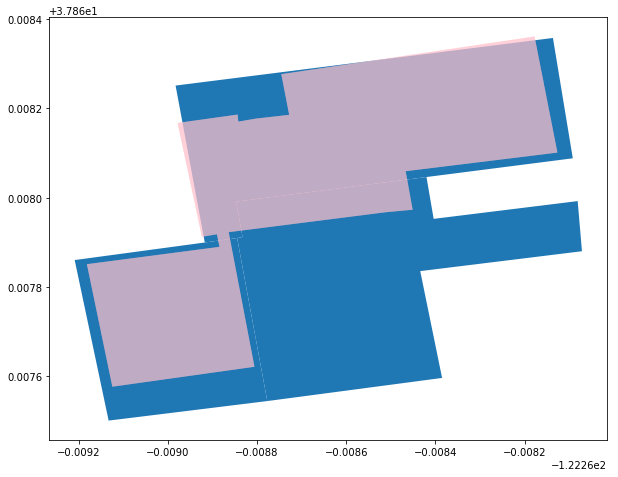

In [181]:
print len(fixes['Union parcels'])
for parcel_sets in fixes['Union parcels'][10:11]:
    print feature_to_maps_link(parcel_sets.head(1))
    print parcel_sets.head(1).name
    two_layer_map(parcel_sets, split_parcels.loc[parcel_sets.index_right])

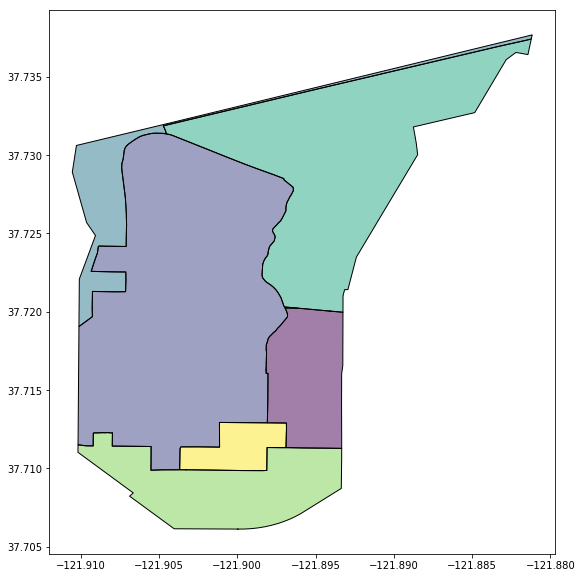

In [118]:
apns = new_parcels.apn.unique()
new_parcels[new_parcels.apn == apns[0]].plot(figsize=(12, 10))

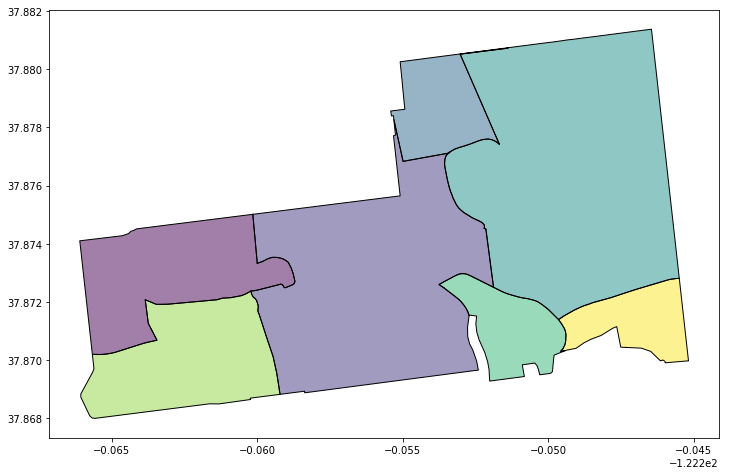

In [119]:
new_parcels[new_parcels.apn == apns[1]].plot(figsize=(12, 10))

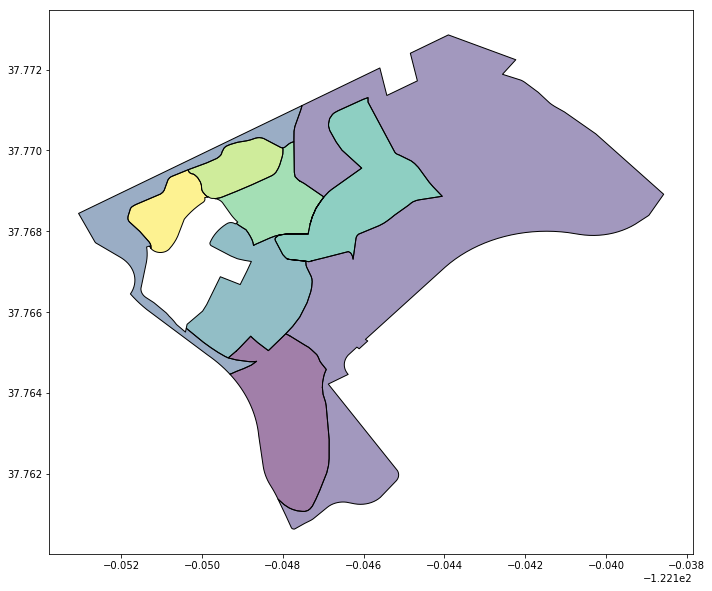

In [120]:
new_parcels[new_parcels.apn == apns[2]].plot(figsize=(12, 10))

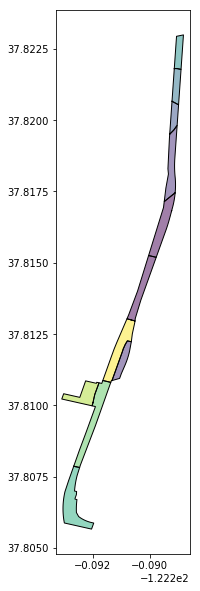

In [121]:
new_parcels[new_parcels.apn == apns[3]].plot(figsize=(12, 10))

In [2]:
buildings = gpd.read_geocsv("buildings.csv", low_memory=False)
neighborhoods = gpd.read_geocsv("ca_neighborhoods.csv")

In [3]:
downtown = neighborhoods[neighborhoods.City == "Oakland"].query("Name == 'Downtown'")
broadmoor = neighborhoods[neighborhoods.City == "San Leandro"].query("Name == 'Broadmoor'")
#downtown_buildings = gpd.sjoin(buildings, downtown)
broadmoor_buildings = gpd.sjoin(buildings, broadmoor)

In [4]:
parcels = gpd.read_geocsv("parcels.csv")
#downtown_parcels = gpd.sjoin(parcels, downtown)
broadmoor_parcels = gpd.sjoin(parcels, broadmoor)

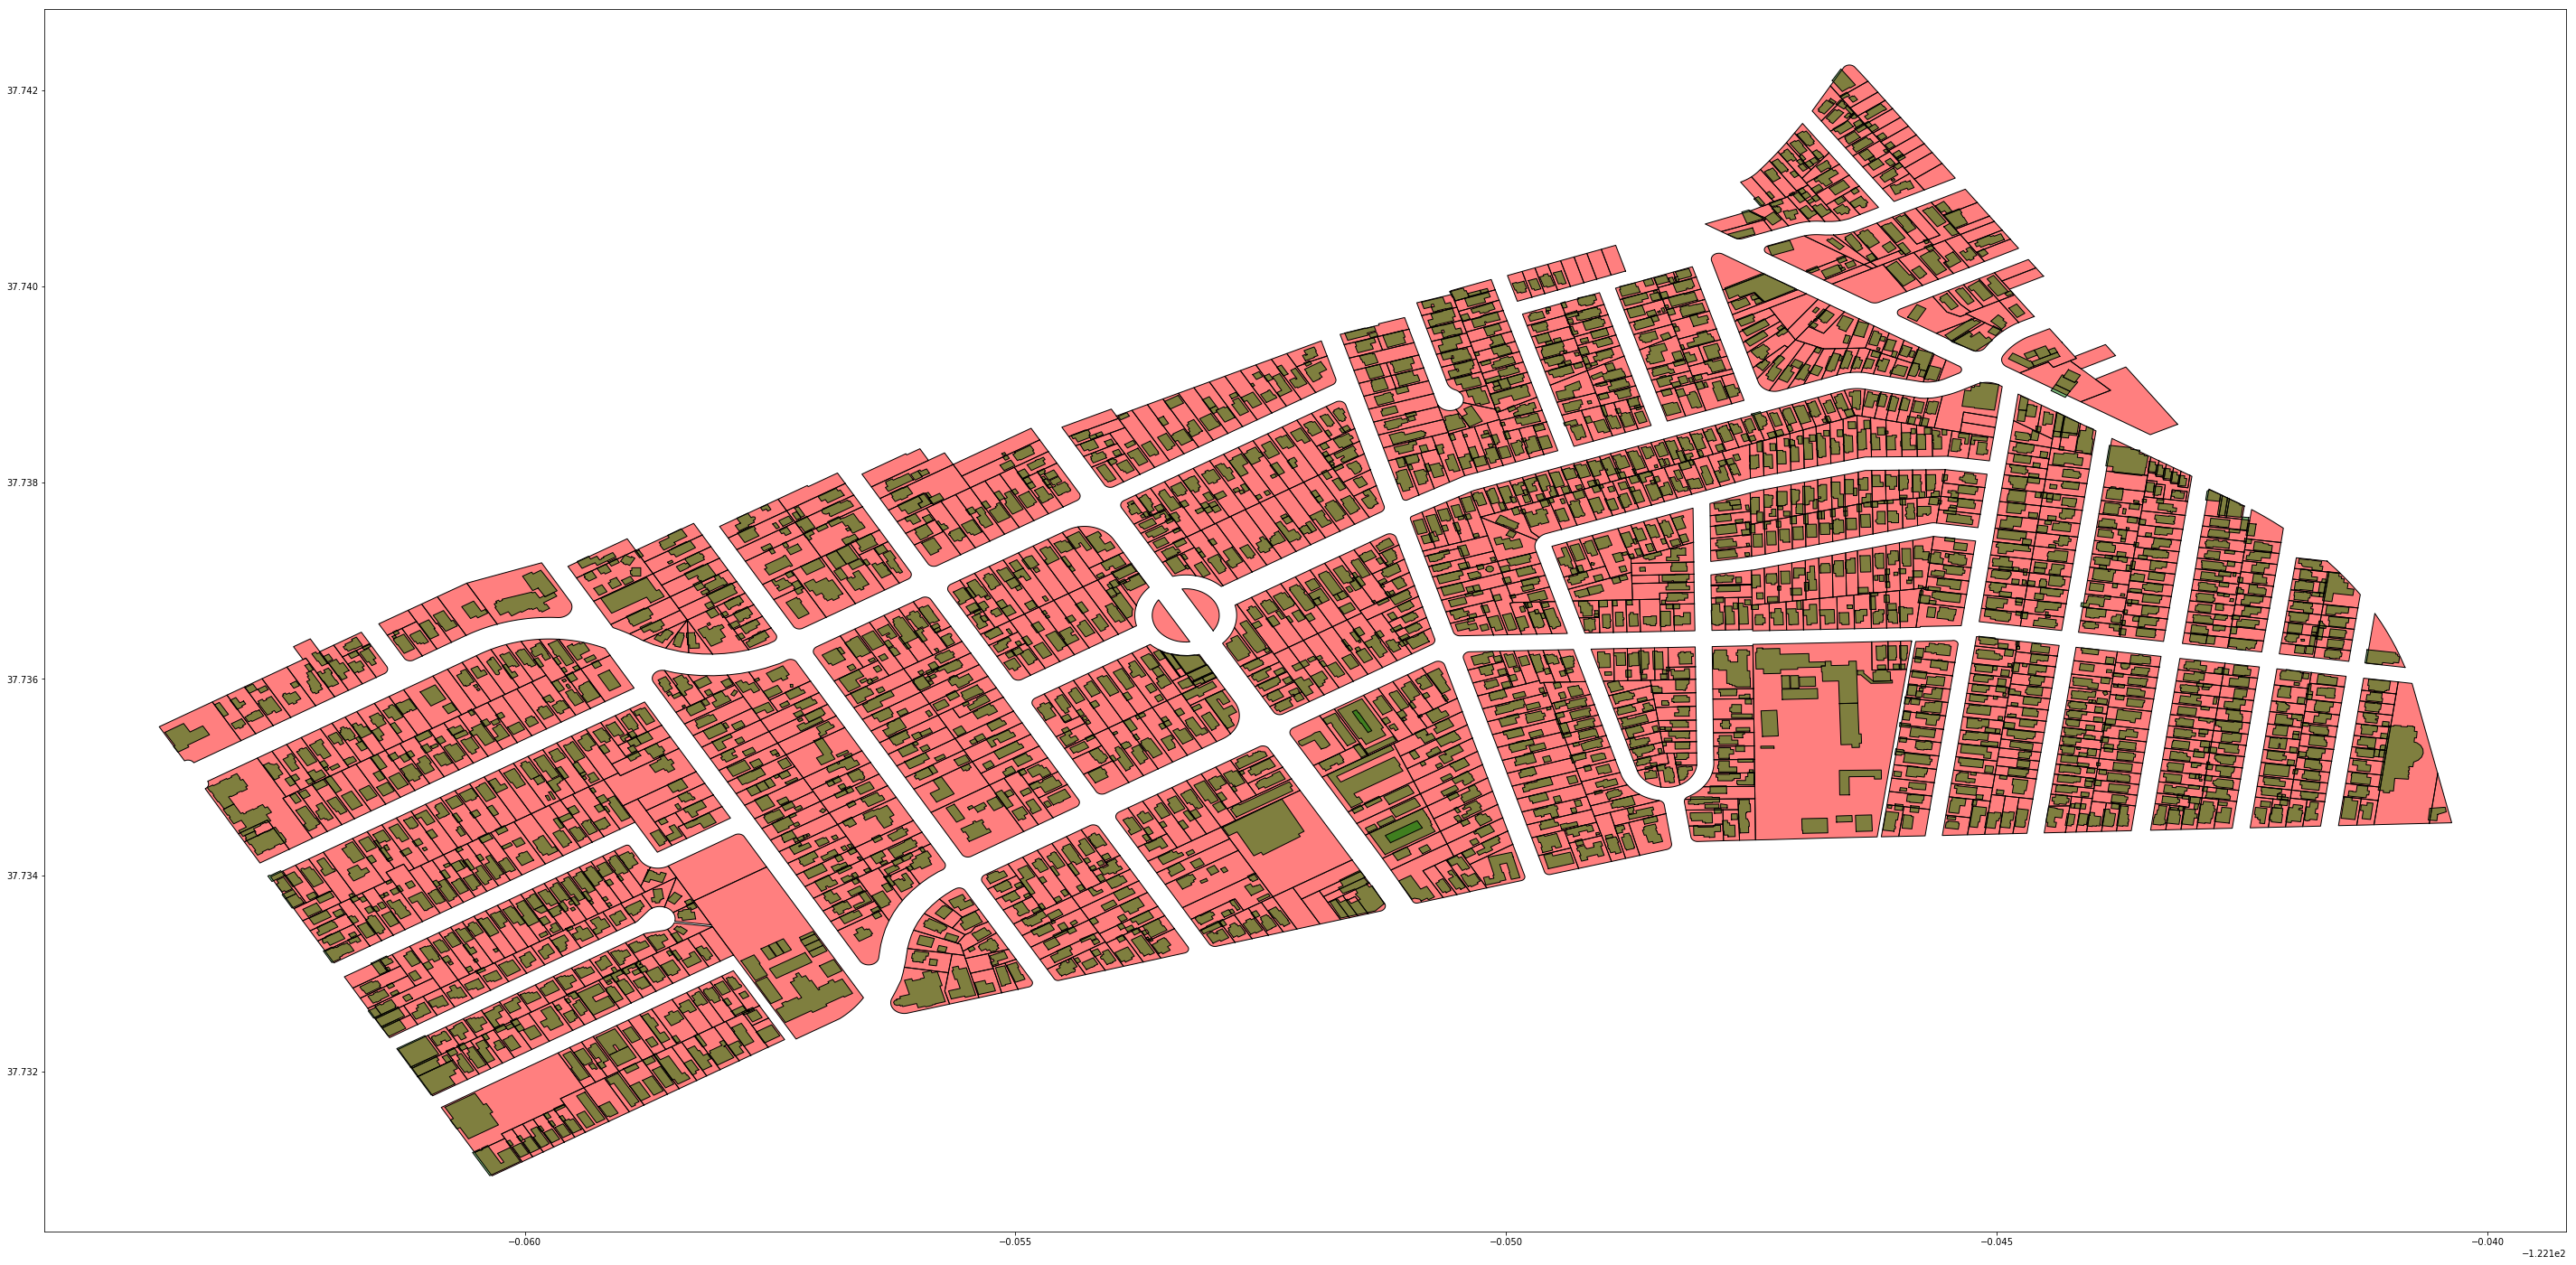

In [5]:
ax = broadmoor_parcels.plot(color='red', figsize=(50, 50))
broadmoor_buildings.plot(ax=ax, color='green', alpha=0.5)

In [44]:
neighborhoods[neighborhoods.City == "San Leandro"]\

,City,County,Name,RegionID,State,geometry
119,San Leandro,Alameda,Broadmoor,113928,CA,"POLYGON ((-122.140476 37.735529, -122.14020628..."
190,San Leandro,Alameda,Mulford Gardens,116799,CA,"POLYGON ((-122.189862 37.700818, -122.189851 3..."
214,San Leandro,Alameda,Bonaire,127284,CA,"POLYGON ((-122.162397427 37.69274821700003, -1..."
1500,San Leandro,Alameda,Mission Bay Mobile Home Park,762530,CA,POLYGON ((-122.1584390789999 37.67904305500008...
1501,San Leandro,Alameda,Davis West,762531,CA,"POLYGON ((-122.182412536 37.724629, -122.18216..."
1680,San Leandro,Alameda,Marina Faire,762532,CA,POLYGON ((-122.1679193259999 37.69143418800007...
1681,San Leandro,Alameda,Floresta Gardens,762534,CA,POLYGON ((-122.1454011279999 37.70614521900006...
1686,San Leandro,Alameda,Heron Bay-Marina Vista,762691,CA,"(POLYGON ((-122.154948704 37.67503778100007, -..."
1822,San Leandro,Alameda,Bay-O-Vista,762536,CA,POLYGON ((-122.1303027169999 37.73325756100007...
1823,San Leandro,Alameda,Estudiollo Estates,762537,CA,"POLYGON ((-122.140206287 37.73445014800006, -1..."


In [9]:
parcel_building_intersections = intersect(buildings, parcels)

In [10]:
len(parcel_building_intersections)

398587

117636
464 012000105
37.6219819959 -122.074616962


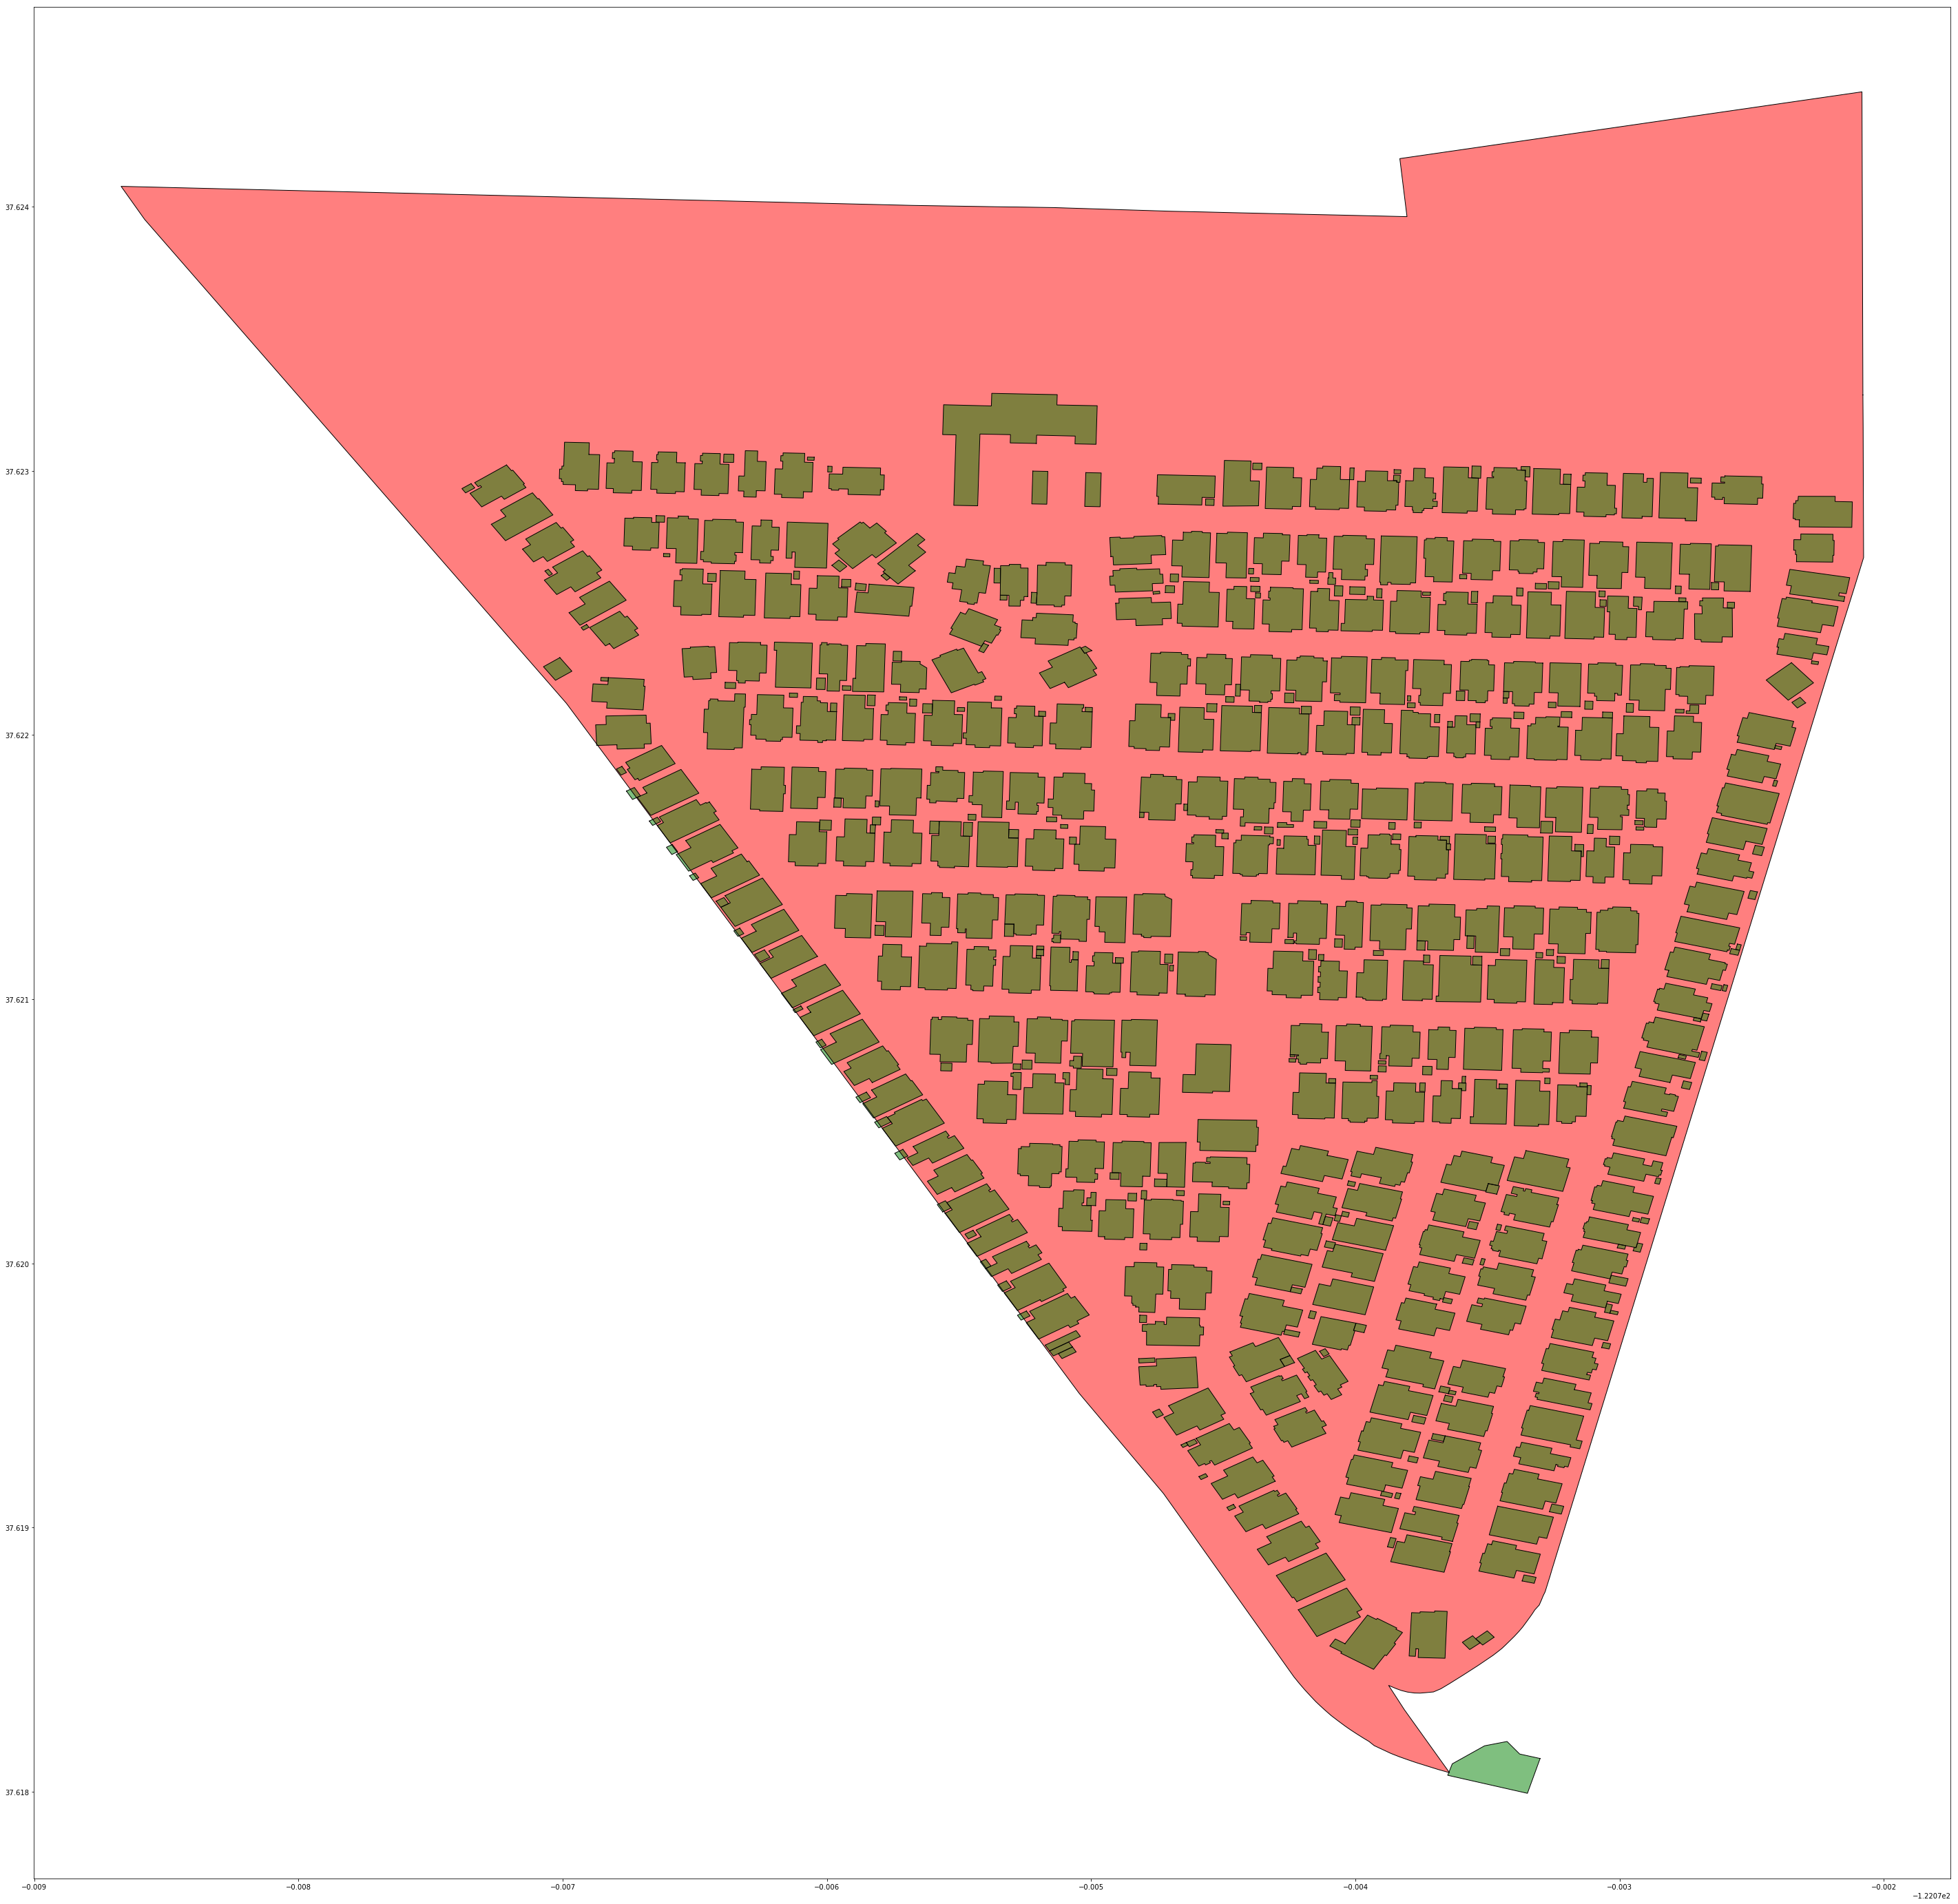

In [36]:
s = parcel_building_intersections.apn.value_counts()
s = s[s > 1]
print len(s)
apn = s.index[0]
print apn
c = parcels[parcels.apn == apn].centroid.geometry.values[0]
print c.y, c.x
ax = parcels[parcels.apn == apn].plot(color='red', figsize=(50, 50))
parcel_building_intersections[parcel_building_intersections.apn == apn].plot(ax=ax, color='green', alpha=0.5)